File: Project-HorseRacing-HongKong.ipynb  
Name: Corinne Medeiros  
Date: 5/30/20    
Description: Horse Racing in Hong Kong - Graph Analysis, Dimensionality and Feature Reduction, Model Evaluation and Selection to predict which horses will win.

In [6]:
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from scipy.stats import spearmanr
from scipy.stats import kendalltau

import yellowbrick
from yellowbrick.features import Rank2D  # correlation visualization package
from yellowbrick.style import set_palette  # color for yellowbrick visualizer
from yellowbrick.features import ParallelCoordinates

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC

## Analyzing Hong Kong horse racing data to predict which horses will win

![horse race](https://images.unsplash.com/photo-1507514604110-ba3347c457f6?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=1350&q=80 "Horse Racing")

*Photo by Mathew Schwartz on Unsplash*

### Narrative: 

For this project, I’m using Hong Kong horse racing data from Kaggle.com (<https://www.kaggle.com/gdaley/hkracing>) to predict which kinds of horses win races. Factors to be considered are the horse’s age, weight, type, and country of origin. The type variable is comprised of the sex and age-related categories of a horse, specifically 'Gelding', 'Mare', 'Horse', 'Rig', 'Colt', and 'Filly' (Daley, 2019).  

Horse racing is a giant industry in Hong Kong, with “betting pools bigger than all US racetracks combined” (Daley, 2019). Predicting wins could potentially lead to major financial gain for those interested in placing bets. Although I don’t necessarily condone horse racing, by analyzing the data I can hopefully bring more awareness to the subject and encourage discussions about it.

## Part 1: Graph Analysis

### Load and preview data

In [7]:
# Loading data
file = "runs.csv"
horse_racing_data = pd.read_csv(file)

In [8]:
# Checking dimensions of the table
print("The dimension of the table is: ", horse_racing_data.shape)

The dimension of the table is:  (79447, 37)


In [9]:
# Previewing data
horse_racing_data.head(5)

,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_country,horse_type,horse_rating,...,time2,time3,time4,time5,time6,finish_time,win_odds,place_odds,trainer_id,jockey_id
0,0,1,3917,10,0.0,8.00,3,AUS,Gelding,60,...,21.59,23.86,24.62,NaN,NaN,83.92,9.7,3.7,118,2
1,0,2,2157,8,0.0,5.75,3,NZ,Gelding,60,...,21.99,23.30,23.70,NaN,NaN,83.56,16.0,4.9,164,57
2,0,3,858,7,0.0,4.75,3,NZ,Gelding,60,...,21.59,23.90,24.22,NaN,NaN,83.40,3.5,1.5,137,18
3,0,4,1853,9,0.0,6.25,3,SAF,Gelding,60,...,21.83,23.70,24.00,NaN,NaN,83.62,39.0,11.0,80,59
4,0,5,2796,6,0.0,3.75,3,GB,Gelding,60,...,21.75,23.22,23.50,NaN,NaN,83.24,50.0,14.0,9,154


### Observations so far  
> a.	Won is represented as a 1 (won) or 0 (otherwise)  
b.	Missing data is represented as “NaN”  
c.	The Won variable will be the “target” and the other variables will be the “features”  

### Data cleanup & summaries

In [10]:
# Checking missing data
horse_racing_data.isna().sum()

race_id                0
horse_no               0
horse_id               0
result                 0
won                    0
lengths_behind         0
horse_age              0
horse_country          2
horse_type             2
horse_rating           0
horse_gear             0
declared_weight        0
actual_weight          0
draw                   0
position_sec1          0
position_sec2          0
position_sec3          0
position_sec4      33221
position_sec5      69368
position_sec6      78151
behind_sec1            0
behind_sec2            0
behind_sec3            0
behind_sec4        33221
behind_sec5        69368
behind_sec6        78151
time1                  0
time2                  0
time3                  0
time4              33221
time5              69368
time6              78151
finish_time            0
win_odds               0
place_odds          3735
trainer_id             0
jockey_id              0
dtype: int64

In [11]:
# Removing columns with large amounts of missing data
horse_racing_data = horse_racing_data.drop(columns=['position_sec4', 'position_sec5', 'position_sec6', 
                                                    'behind_sec4', 'behind_sec5','behind_sec6', 'time4', 
                                                    'time5', 'time6', 'place_odds'])

# Looking at the data
horse_racing_data.head(5)

,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_country,horse_type,horse_rating,...,behind_sec1,behind_sec2,behind_sec3,time1,time2,time3,finish_time,win_odds,trainer_id,jockey_id
0,0,1,3917,10,0.0,8.00,3,AUS,Gelding,60,...,2.00,2.00,1.50,13.85,21.59,23.86,83.92,9.7,118,2
1,0,2,2157,8,0.0,5.75,3,NZ,Gelding,60,...,6.50,9.00,5.00,14.57,21.99,23.30,83.56,16.0,164,57
2,0,3,858,7,0.0,4.75,3,NZ,Gelding,60,...,1.00,1.00,0.75,13.69,21.59,23.90,83.40,3.5,137,18
3,0,4,1853,9,0.0,6.25,3,SAF,Gelding,60,...,3.50,5.00,3.50,14.09,21.83,23.70,83.62,39.0,80,59
4,0,5,2796,6,0.0,3.75,3,GB,Gelding,60,...,7.75,8.75,4.25,14.77,21.75,23.22,83.24,50.0,9,154


### Questions that might help predict which horses will win:  

> a. What do the variables look like? For example, are they numerical or categorical data? If they are numerical, what are their distribution; if they are categorical, how many are there in different categories?  

> b. Are the numerical variables correlated?  

> c. Is the winning rate different for different types of horses? For example, were horses more likely to win if they were younger, or a gelding vs. a filly?  

> d. Are there different winning rates for different countries? For example, did more horses from Australia win than horses from New Zealand?  

### Data summary information

In [12]:
# What type of variables are in the table 

print("Describe Data:\n")
print(horse_racing_data.describe())

print("\nSummarized Data:\n")
print(horse_racing_data.describe(include=['O']))

Describe Data:

            race_id      horse_no      horse_id        result           won  \
count  79447.000000  79447.000000  79447.000000  79447.000000  79447.000000   
mean    3173.352814      6.905623   2204.410525      6.838597      0.080053   
std     1833.101494      3.760711   1275.049375      3.730498      0.271378   
min        0.000000      1.000000      0.000000      1.000000      0.000000   
25%     1586.000000      4.000000   1085.000000      4.000000      0.000000   
50%     3174.000000      7.000000   2209.000000      7.000000      0.000000   
75%     4764.500000     10.000000   3308.000000     10.000000      0.000000   
max     6348.000000     14.000000   4404.000000     14.000000      1.000000   

       lengths_behind     horse_age  horse_rating  declared_weight  \
count    79447.000000  79447.000000  79447.000000     79447.000000   
mean         6.108901      3.339346     61.034904      1104.953568   
std         33.636209      0.876763     11.748788        62.34

In [13]:
# Replacing missing values in horse type
horse_racing_data['horse_type'] = horse_racing_data['horse_type'].fillna('Unknown')

# Checking missing values
print(horse_racing_data['horse_type'].isna().sum())

0


In [14]:
# Replacing missing values in horse country
horse_racing_data['horse_country'] = horse_racing_data['horse_country'].fillna('Unknown')

# Checking missing values
print(horse_racing_data['horse_country'].isna().sum())

0


### Conclusions based on data summaries

> Looking at the descriptive summary information about the data, I can tell that most race horses are of a certain age because of the similar percentiles, so there won't be much variety there. I can also conclude that horse type and country have a smaller amount of unique values that will be fitting for bar charts. 

### Data Visualization: Histograms  

> At the start of the race, the majority of horses have a Hong Kong Jockey Club rating of 60. Horse ranking for section 1 of the race is pretty uniformly distributed, while the win odds are right skewed. Together, most horses and their jockeys weigh between 1000 lbs and 1200 lbs, and the data form a normal distribution.

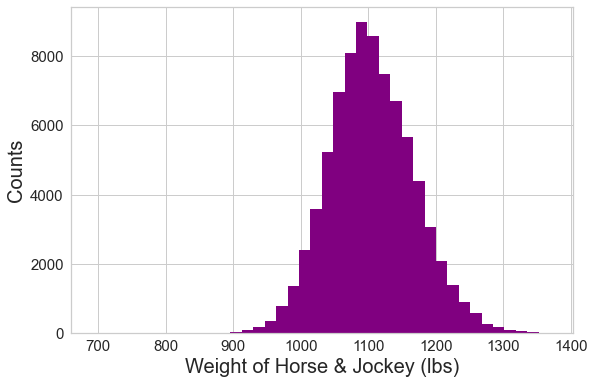

In [15]:
# Setting figure and size
plt.figure(figsize=(9, 6))
plt.subplot()

# Histogram of horse and jockey weight
plt.hist(horse_racing_data['declared_weight'], color='purple', bins=40)
plt.xlabel('Weight of Horse & Jockey (lbs)', fontsize=20)  # Adding an x-label
plt.ylabel('Counts', fontsize=20)  # Adding a y-label
plt.tick_params(axis='both', labelsize=15)  # Setting font size of labels

plt.show()

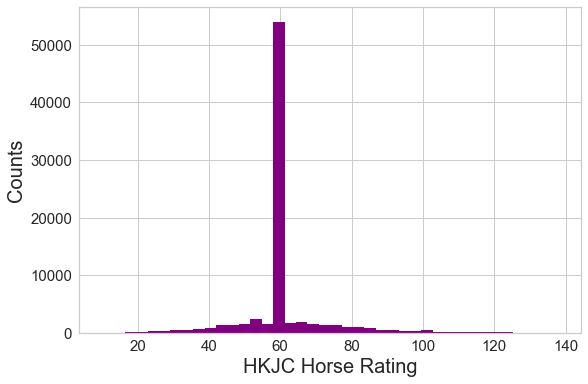

In [16]:
# Setting figure and size
plt.figure(figsize=(9, 6))
plt.subplot()

# Histogram of Hong Kong Jockey Club horse rating
plt.hist(horse_racing_data['horse_rating'], color='purple', bins=40)
plt.xlabel('HKJC Horse Rating', fontsize=20)  # Adding an x-label
plt.ylabel('Counts', fontsize=20)  # Adding a y-label
plt.tick_params(axis='both', labelsize=15)  # Setting font size of labels

plt.show()

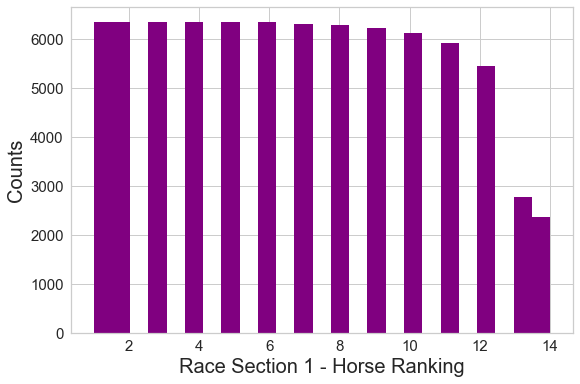

In [17]:
# Setting figure and size
plt.figure(figsize=(9, 6))
plt.subplot()

# Histogram of horse ranking in section 1 of race
plt.hist(horse_racing_data['position_sec1'], color='purple', bins=25)
plt.xlabel('Race Section 1 - Horse Ranking', fontsize=20)  # Adding an x-label
plt.ylabel('Counts', fontsize=20)  # Adding a y-label
plt.tick_params(axis='both', labelsize=15)  # Setting font size of labels

plt.show()

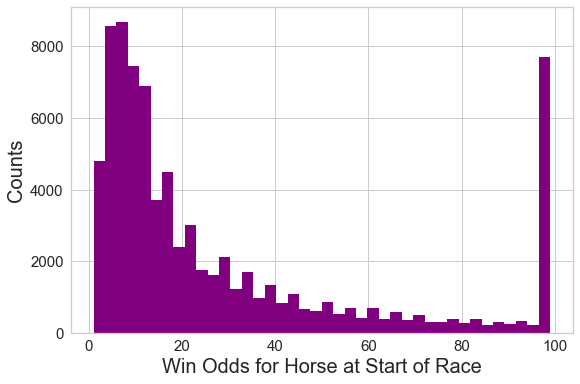

In [18]:
# Setting figure and size
plt.figure(figsize=(9, 6))
plt.subplot()

# Histogram of horse ranking in section 1 of race
plt.hist(horse_racing_data['win_odds'], color='purple', bins=40)
plt.xlabel('Win Odds for Horse at Start of Race', fontsize=20)  # Adding an x-label
plt.ylabel('Counts', fontsize=20)  # Adding a y-label
plt.tick_params(axis='both', labelsize=15)  # Setting font size of labels

plt.show()

### Data Visualization: Bar Charts

> From the following bar charts, we can see that the majority of the horses are 3 year old geldings (castrated male horses) from Australia and New Zealand.

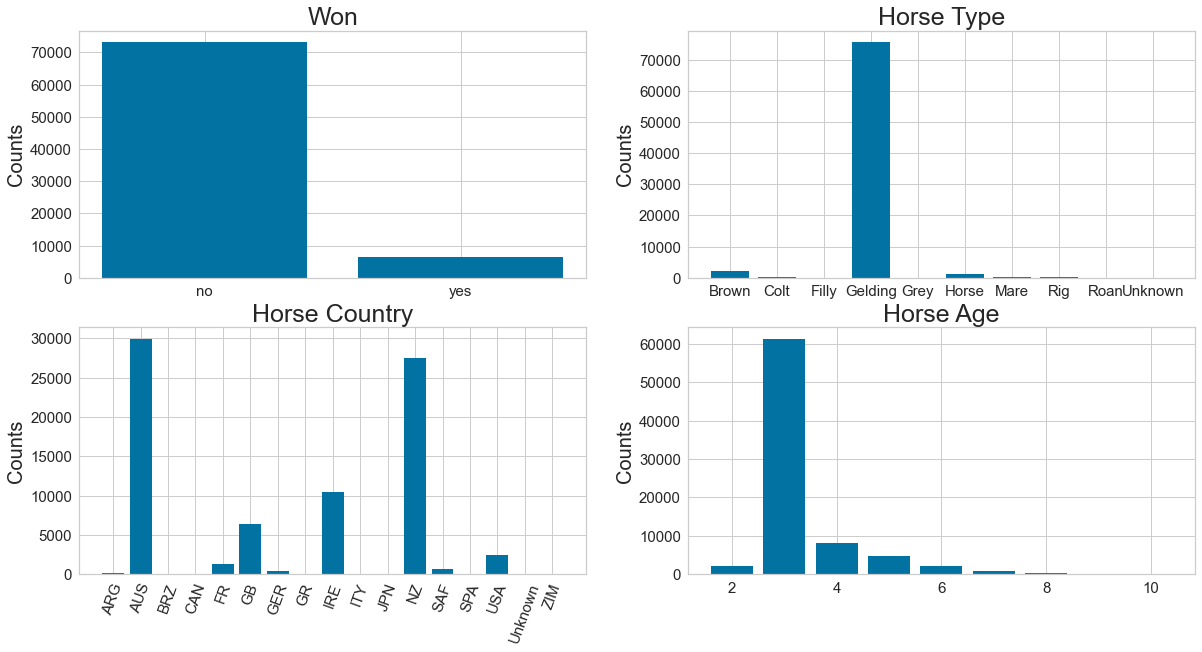

In [19]:
# Setting up the figure size
plt.rcParams['figure.figsize'] = (20, 10)

# Making subplots
fig, axes = plt.subplots(nrows = 2, ncols = 2)

# --WON--

# make the data read to feed into the visualizer
X_Won = horse_racing_data.replace({'won': {1: 'yes', 0: 'no'}}).groupby('won').size().reset_index(name='Counts')['won']
Y_Won = horse_racing_data.replace({'won': {1: 'yes', 0: 'no'}}).groupby('won').size().reset_index(name='Counts')['Counts']
# make the bar plot
axes[0, 0].bar(X_Won, Y_Won)
axes[0, 0].set_title('Won', fontsize=25)
axes[0, 0].set_ylabel('Counts', fontsize=20)
axes[0, 0].tick_params(axis='both', labelsize=15)

# --TYPE--

# make the data read to feed into the visualizer
X_HorseType = horse_racing_data.groupby('horse_type').size().reset_index(name='Counts')['horse_type']
Y_HorseType = horse_racing_data.groupby('horse_type').size().reset_index(name='Counts')['Counts']
# make the bar plot
axes[0, 1].bar(X_HorseType, Y_HorseType)
axes[0, 1].set_title('Horse Type', fontsize=25)
axes[0, 1].set_ylabel('Counts', fontsize=20)
axes[0, 1].tick_params(axis='both', labelsize=15)

# --COUNTRY--

# make the data read to feed into the visualizer
X_Country = horse_racing_data.groupby('horse_country').size().reset_index(name='Counts')['horse_country']
Y_Country = horse_racing_data.groupby('horse_country').size().reset_index(name='Counts')['Counts']
# make the bar plot
axes[1, 0].bar(X_Country, Y_Country)
axes[1, 0].set_title('Horse Country', fontsize=25)
axes[1, 0].set_ylabel('Counts', fontsize=20)
axes[1, 0].tick_params(axis='x', labelsize=15, labelrotation=70)
axes[1, 0].tick_params(axis='y', labelsize=15)

# --AGE--

# make the data read to feed into the visualizer
X_Age = horse_racing_data.groupby('horse_age').size().reset_index(name='Counts')['horse_age']
Y_Age = horse_racing_data.groupby('horse_age').size().reset_index(name='Counts')['Counts']
# make the bar plot
axes[1, 1].bar(X_Age, Y_Age)
axes[1, 1].set_title('Horse Age', fontsize=25)
axes[1, 1].set_ylabel('Counts', fontsize=20)
axes[1, 1].tick_params(axis='both', labelsize=15)

plt.show()

### Correlation: Pearson Ranking charts  

> The correlation between the variables is low. These results show there is a little positive correlation (section 1 position and win odds) and a little negative correlation (section 1 position and weight) but these numbers are not significant.

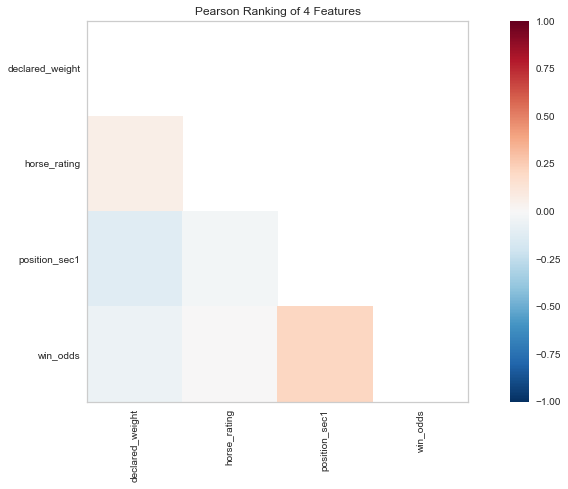

In [20]:
# Pearson Ranking

#set up the figure size
plt.rcParams['figure.figsize'] = (15, 7)

features = ['declared_weight', 'horse_rating', 'position_sec1', 'win_odds']

# extract the numpy arrays from the data frame
X = horse_racing_data[features].values

# instantiate the visualizer with the Covariance ranking algorithm
visualizer = Rank2D(features=features, algorithm='pearson')
visualizer.fit(X)                # Fit the data to the visualizer
visualizer.transform(X)             # Transform the data
visualizer.poof(outpath="pearson_ranking.png") # Draw/show/poof the data
plt.show()

### Correlation: Spearman's rank & Kendall's rank  

> Since some of my variables are ordinal and don't have normal distributions, I'll also compute Spearman's rank correlation and Kendall’s rank correlation. 

> I'll check for correlation between horse_rating (the rating number assigned by HKJC at the time of the race), position_sec1 (position of this horse in section 1 of the race), and win_odds (win odds for this horse at start of race).

In [21]:
# calculate spearman's correlation - horse_rating vs position_sec1
coef, p = spearmanr(horse_racing_data['horse_rating'], horse_racing_data['position_sec1'])
print('horse_rating vs position_sec1:')
print('Spearmans correlation coefficient: %.3f' % coef)

# interpret the significance
alpha = 0.05
if p > alpha:
    print('Features are uncorrelated. p=%.5f' % p)
else:
    print('Features are correlated. p=%.5f' % p)
    
print('\n')
    
# calculate spearman's correlation - horse_rating vs win_odds
coef2, p2 = spearmanr(horse_racing_data['horse_rating'], horse_racing_data['win_odds'])
print('horse_rating vs win_odds:')
print('Spearmans correlation coefficient: %.3f' % coef2)

# interpret the significance
alpha = 0.05
if p2 > alpha:
    print('Features are uncorrelated. p=%.5f' % p2)
else:
    print('Features are correlated. p=%.5f' % p2)

horse_rating vs position_sec1:
Spearmans correlation coefficient: -0.012
Features are correlated. p=0.00048


horse_rating vs win_odds:
Spearmans correlation coefficient: 0.004
Features are uncorrelated. p=0.25680


In [22]:
# calculate kendall's correlation - horse_rating vs position_sec1
k_coef, k_p = kendalltau(horse_racing_data['horse_rating'], horse_racing_data['position_sec1'])
print('horse_rating vs position_sec1:')
print('Kendall correlation coefficient: %.3f' % k_coef)

# interpret the significance
alpha = 0.05
if k_p > alpha:
    print('Features are uncorrelated. p=%.3f' % k_p)
else:
    print('Features are correlated. p=%.3f' % k_p)
    
print('\n')    

# calculate kendall's correlation - horse_rating vs win_odds
k_coef2, k_p2 = kendalltau(horse_racing_data['horse_rating'], horse_racing_data['win_odds'])
print('horse_rating vs win_odds:')
print('Kendall correlation coefficient: %.3f' % k_coef2)

# interpret the significance
alpha = 0.05
if k_p2 > alpha:
    print('Features are uncorrelated. p=%.3f' % k_p2)
else:
    print('Features are correlated. p=%.3f' % k_p2)

horse_rating vs position_sec1:
Kendall correlation coefficient: -0.010
Features are correlated. p=0.000


horse_rating vs win_odds:
Kendall correlation coefficient: 0.003
Features are uncorrelated. p=0.207


> Based on these calculations, we can confirm that there is some negative correlation between horse_rating and position_sec1, but it's very small. Also, horse_rating and win_odds are uncorrelated.

### Data Visualization: Parallel Coordinates   

In [23]:
# copy data to a new dataframe
horse_racing_data_norm = horse_racing_data.copy()

In [24]:
# normalize data to 0-1 range
for feature in features:
    horse_racing_data_norm[feature] = ((horse_racing_data[feature] - horse_racing_data[feature].mean()) 
                                       / (horse_racing_data[feature].max() - horse_racing_data[feature].min()))

In [25]:
# Extract the numpy arrays from the data frame
X = horse_racing_data_norm[features].values
y = horse_racing_data.won.values

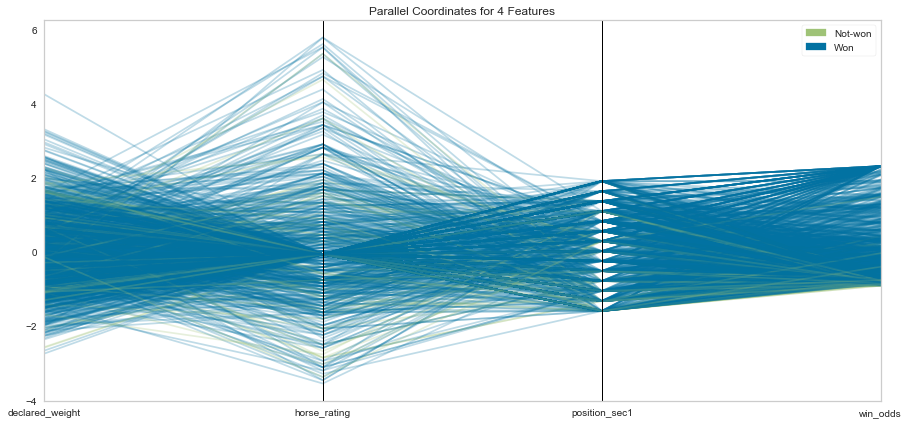

In [21]:
#set up the figure size
plt.rcParams['font.size'] = 50

# Specify the features of interest and the classes of the target
classes = ['Won', 'Not-won']
features = ['declared_weight', 'horse_rating', 'position_sec1', 'win_odds']

# Instantiate the visualizer
visualizer = ParallelCoordinates(
    classes=classes, features=features,
    normalize='standard', sample=0.02, shuffle=True,
)

visualizer.fit_transform(X, y)      # Fit the data to the visualizer
visualizer.poof(outpath="parallelcoords.png") # Draw/show/poof the data
plt.show()

> With Parallel Coordinates we are able to compare the distributions of numerical variables between horses that won and those that did not win.  

> Horses with a higher ranking have a higher chance of winning. The rest of the graph is pretty dense even with the smaller sample size, but it seems like higher weight might mean more chance of winning as well but it's hard to tell. 

### Stacked Bar Charts

> Using stacked bar charts we can compare horses that won to horses that didn’t win based on other variables.

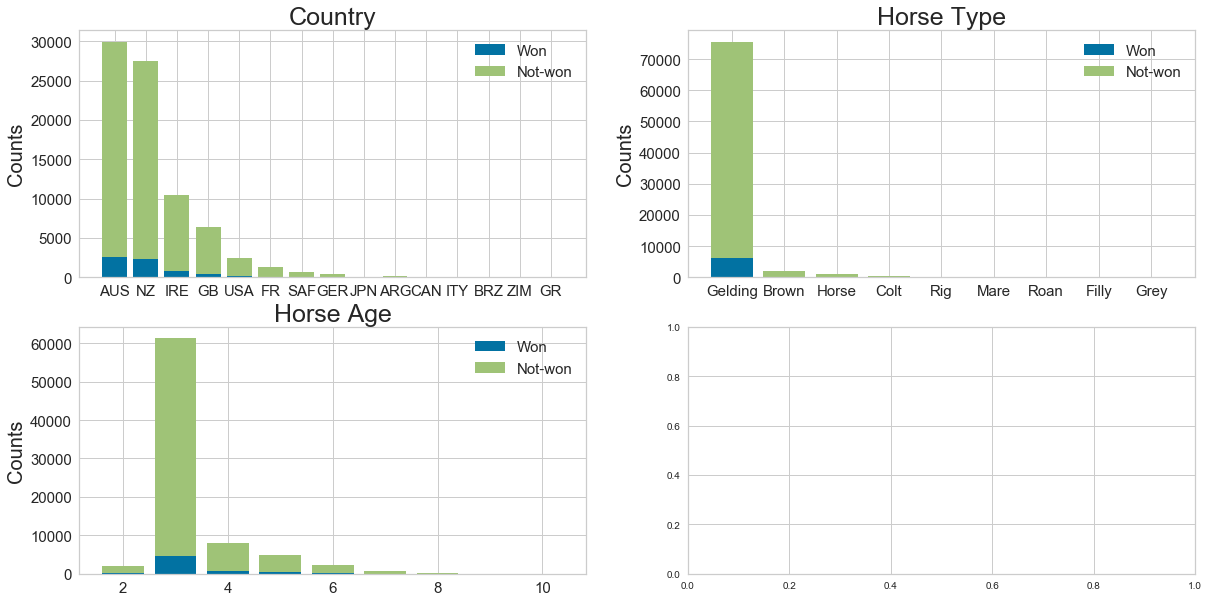

In [22]:
# Stacked bar charts to compare won/not won

#set up the figure size
plt.rcParams['figure.figsize'] = (20, 10)

# make subplots
fig, axes = plt.subplots(nrows = 2, ncols = 2)


# --COUNTRY--

# make the data read to feed into the visualizer
Country_won = horse_racing_data.replace({'won': {1: 'Won', 0: 'Not-won'}})[horse_racing_data['won']==1]['horse_country'].value_counts()
Country_not_won = horse_racing_data.replace({'won': {1: 'Won', 0: 'Not-won'}})[horse_racing_data['won']==0]['horse_country'].value_counts()
Country_not_won = Country_not_won.reindex(index = Country_won.index)
# make the bar plot
p1 = axes[0, 0].bar(Country_won.index, Country_won.values)
p2 = axes[0, 0].bar(Country_not_won.index, Country_not_won.values, bottom=Country_won.values)
axes[0, 0].set_title('Country', fontsize=25)
axes[0, 0].set_ylabel('Counts', fontsize=20)
axes[0, 0].tick_params(axis='both', labelsize=15)
axes[0, 0].legend((p1[0], p2[0]), ('Won', 'Not-won'), fontsize = 15)


# --TYPE--

# make the data read to feed into the visualizer
Type_won = horse_racing_data.replace({'won': {1: 'Won', 0: 'Not-won'}})[horse_racing_data['won']==1]['horse_type'].value_counts()
Type_not_won = horse_racing_data.replace({'won': {1: 'Won', 0: 'Not-won'}})[horse_racing_data['won']==0]['horse_type'].value_counts()
Type_not_won = Type_not_won.reindex(index = Type_won.index)
# make the bar plot
p3 = axes[0, 1].bar(Type_won.index, Type_won.values)
p4 = axes[0, 1].bar(Type_not_won.index, Type_not_won.values, bottom=Type_won.values)
axes[0, 1].set_title('Horse Type', fontsize=25)
axes[0, 1].set_ylabel('Counts', fontsize=20)
axes[0, 1].tick_params(axis='both', labelsize=15)
axes[0, 1].legend((p3[0], p4[0]), ('Won', 'Not-won'), fontsize = 15)


# --AGE--

# make the data read to feed into the visualizer
Age_won = horse_racing_data.replace({'won': {1: 'Won', 0: 'Not-won'}})[horse_racing_data['won']==1]['horse_age'].value_counts()
Age_not_won = horse_racing_data.replace({'won': {1: 'Won', 0: 'Not-won'}})[horse_racing_data['won']==0]['horse_age'].value_counts()
Age_not_won = Age_not_won.reindex(index = Age_won.index)
# make the bar plot
p5 = axes[1, 0].bar(Age_won.index, Age_won.values)
p6 = axes[1, 0].bar(Age_not_won.index, Age_not_won.values, bottom=Age_won.values)
axes[1, 0].set_title('Horse Age', fontsize=25)
axes[1, 0].set_ylabel('Counts', fontsize=20)
axes[1, 0].tick_params(axis='both', labelsize=15)
axes[1, 0].legend((p5[0], p6[0]), ('Won', 'Not-won'), fontsize = 15)

> Horses from Australia won the most, with New Zealand close behind. More geldings won than others.  Also, horses that were age 3 won the most.

## Part 2: Dimensionality and Feature Reduction  

> The features I will get rid of are:  "race_id", "horse_no", "horse_id", "trainer_id", and "jockey_id."  (ID doesn’t give us useful data, and "horse_gear" has too many unique combinations)  

> We can also fill in missing values. Since I filled in 2 missing values for horse_type and horse_country earlier with "Unknown", I am going to replace those "Unknown" values with the most common values. 

In [23]:
# Replacing "Unknown" values with "NaN"
horse_racing_data = horse_racing_data.replace('Unknown', np.nan)

In [24]:
# Checking for missing values
print(horse_racing_data.isna().sum())

race_id            0
horse_no           0
horse_id           0
result             0
won                0
lengths_behind     0
horse_age          0
horse_country      2
horse_type         2
horse_rating       0
horse_gear         0
declared_weight    0
actual_weight      0
draw               0
position_sec1      0
position_sec2      0
position_sec3      0
behind_sec1        0
behind_sec2        0
behind_sec3        0
time1              0
time2              0
time3              0
finish_time        0
win_odds           0
trainer_id         0
jockey_id          0
dtype: int64


In [25]:
# Filling in missing horse_type and horse_country data with most represented values

horse_racing_data['horse_type'].fillna('Gelding', inplace=True)

horse_racing_data['horse_country'].fillna('AUS', inplace=True)

In [26]:
# Checking results

print('horse_type:\n', horse_racing_data['horse_type'].describe())

print('\nhorse_country:\n', horse_racing_data['horse_country'].describe())

horse_type:
 count       79447
unique          9
top       Gelding
freq        75505
Name: horse_type, dtype: object

horse_country:
 count     79447
unique       16
top         AUS
freq      29908
Name: horse_country, dtype: object


### Log Transformation for highly skewed data  

> If you go back and look at the histograms of win_odds, you’ll see that it is very skewed… many low odds, not very many high odds.  

> Since the win_odds variable is highly skewed, I'm going to apply a log transformation.

In [27]:
# log-transformation of win_odds
def log_transformation(data):
    return data.apply(np.log1p)

horse_racing_data['win_odds_log1p'] = log_transformation(horse_racing_data['win_odds'])

# check the data
print(horse_racing_data.describe())

            race_id      horse_no      horse_id        result           won  \
count  79447.000000  79447.000000  79447.000000  79447.000000  79447.000000   
mean    3173.352814      6.905623   2204.410525      6.838597      0.080053   
std     1833.101494      3.760711   1275.049375      3.730498      0.271378   
min        0.000000      1.000000      0.000000      1.000000      0.000000   
25%     1586.000000      4.000000   1085.000000      4.000000      0.000000   
50%     3174.000000      7.000000   2209.000000      7.000000      0.000000   
75%     4764.500000     10.000000   3308.000000     10.000000      0.000000   
max     6348.000000     14.000000   4404.000000     14.000000      1.000000   

       lengths_behind     horse_age  horse_rating  declared_weight  \
count    79447.000000  79447.000000  79447.000000     79447.000000   
mean         6.108901      3.339346     61.034904      1104.953568   
std         33.636209      0.876763     11.748788        62.347597   
min     

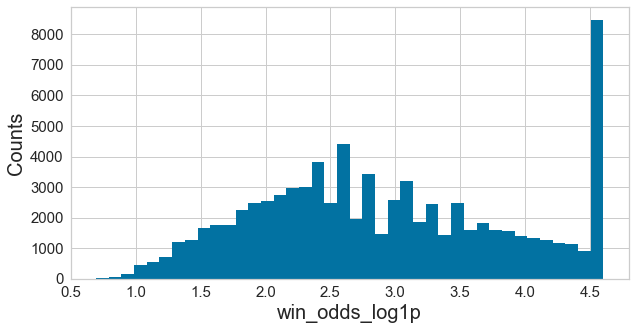

In [28]:
# adjust skewed data (win_odds)
# check the distribution using histogram

# set up the figure size
plt.rcParams['figure.figsize'] = (10, 5)

plt.hist(horse_racing_data['win_odds_log1p'], bins=40)
plt.xlabel('win_odds_log1p', fontsize=20)
plt.ylabel('Counts', fontsize=20)
plt.tick_params(axis='both', labelsize=15)
#plt.show()

### Converting categorical data into numbers (Country, Type)

In [29]:
# get the categorical data
cat_features = ['horse_country', 'horse_type']
data_cat = horse_racing_data[cat_features]

# One Hot Encoding 
data_cat_dummies = pd.get_dummies(data_cat)

# check the data
print(data_cat_dummies.head(8))

   horse_country_ARG  horse_country_AUS  horse_country_BRZ  horse_country_CAN  \
0                  0                  1                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   
5                  0                  0                  0                  0   
6                  0                  0                  0                  0   
7                  0                  1                  0                  0   

   horse_country_FR  horse_country_GB  horse_country_GER  horse_country_GR  \
0                 0                 0                  0                 0   
1                 0                 0                  0                 0   
2                 0                 

### Random Forest Classifier  

I chose to use a Random Forest Classifier because of interpretability, and because I'm predicting binary classification. First, I'll remove the columns that don't contain useful information.

In [30]:
# Removing columns containing little useful information
horse_racing_data = horse_racing_data.drop(columns=['race_id', 'horse_no', 'horse_id', 'trainer_id', 'jockey_id'])

# Looking at the data
horse_racing_data.head(5)

,result,won,lengths_behind,horse_age,horse_country,horse_type,horse_rating,horse_gear,declared_weight,actual_weight,...,position_sec3,behind_sec1,behind_sec2,behind_sec3,time1,time2,time3,finish_time,win_odds,win_odds_log1p
0,10,0.0,8.00,3,AUS,Gelding,60,--,1020.0,133,...,6,2.00,2.00,1.50,13.85,21.59,23.86,83.92,9.7,2.370244
1,8,0.0,5.75,3,NZ,Gelding,60,--,980.0,133,...,13,6.50,9.00,5.00,14.57,21.99,23.30,83.56,16.0,2.833213
2,7,0.0,4.75,3,NZ,Gelding,60,--,1082.0,132,...,2,1.00,1.00,0.75,13.69,21.59,23.90,83.40,3.5,1.504077
3,9,0.0,6.25,3,SAF,Gelding,60,--,1118.0,127,...,11,3.50,5.00,3.50,14.09,21.83,23.70,83.62,39.0,3.688879
4,6,0.0,3.75,3,GB,Gelding,60,--,972.0,131,...,12,7.75,8.75,4.25,14.77,21.75,23.22,83.24,50.0,3.931826


In [40]:
# Create features 
features = horse_racing_data.loc[:,['horse_rating', 'declared_weight', 'actual_weight', 'win_odds_log1p',
                                   'position_sec1']]

# Create target
target = horse_racing_data.won

# Display original data
print("Features:  ", features)
print ("Target:  ", target)

# create random forest classifier object
randomforest=RandomForestClassifier(random_state=0, n_jobs=-1, n_estimators=10)

# train model
model_rf = randomforest.fit(features, target)
print(model_rf)


Features:          horse_rating  declared_weight  actual_weight  win_odds_log1p  \
0                60           1020.0            133        2.370244   
1                60            980.0            133        2.833213   
2                60           1082.0            132        1.504077   
3                60           1118.0            127        3.688879   
4                60            972.0            131        3.931826   
5                60           1114.0            127        2.079442   
6                60            978.0            123        4.605170   
7                60           1170.0            128        2.564949   
8                60           1126.0            123        3.663562   
9                60           1072.0            125        3.688879   
10               60           1135.0            123        2.261763   
11               60           1018.0            123        3.178054   
12               60           1089.0            120        1.8562

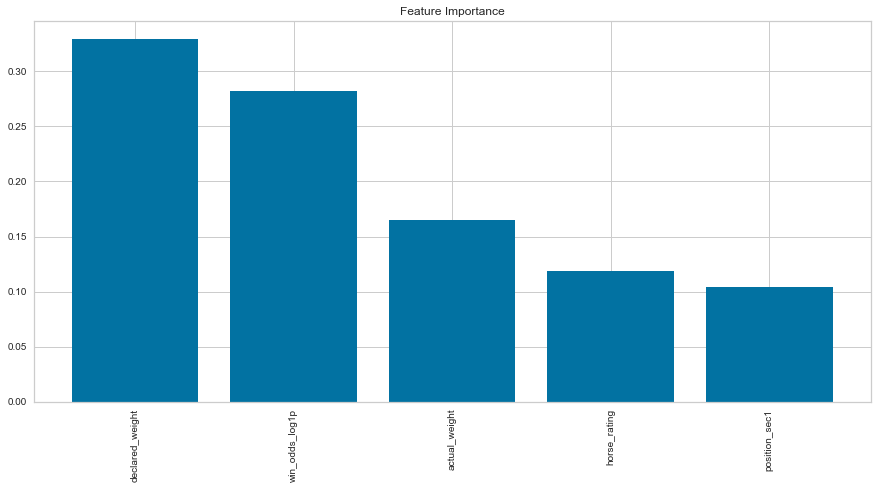

In [41]:
# Calculate feature importances
importances = model_rf.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [features.columns[i] for i in indices]

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(features.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(features.shape[1]), names, rotation=90)

# Show plot
plt.show()

> After calculating and visualizing the features in order of importance, I can see that ‘declared_weight’ is the most important feature, followed by 'win_odds_log1p', 'actual_weight', 'horse_rating', and 'position_sec1'.

## Part 3 - Model Evaluation & Selection

### Training - Splitting data into training and testing  

In [42]:
# Create a whole features dataset that can be used for train and validation data splitting

# Combine numerical features and dummie features together
features_model = ['horse_rating', 'declared_weight', 'actual_weight', 'win_odds_log1p', 'position_sec1']
data_model_X = pd.concat([horse_racing_data[features_model], data_cat_dummies], axis=1)

# Create a whole target dataset that can be used for train and validation data splitting
data_model_y = horse_racing_data.replace({'won': {1: 'won', 0: 'not_won'}})['won']

# separate data into training and validation and check the details of the datasets

# split the data
X_train, X_val, y_train, y_val = train_test_split(data_model_X, data_model_y, test_size =0.3, random_state=11)

# number of samples in each set
print("No. of samples in training set: ", X_train.shape[0])
print("No. of samples in validation set:", X_val.shape[0])

# won and not-won
print('\n')
print('No. of won and not-won in the training set:')
print(y_train.value_counts())

print('\n')
print('No. of won and not-won in the validation set:')
print(y_val.value_counts())

No. of samples in training set:  55612
No. of samples in validation set: 23835


No. of won and not-won in the training set:
not_won    51122
won         4490
Name: won, dtype: int64


No. of won and not-won in the validation set:
not_won    21965
won         1870
Name: won, dtype: int64


### Evaluation

We are trying to predict if a horse has won or not so this is a classification problem. I'm going to use logistic regression.  

Metrics for the evaluation:    

> i. 	  Confusion Matrix  
ii.	   Precision, Recall & F1 score  
iii.    ROC curve  

#### i. Confusion Matrix  

> Since the diagonal doesn't include the largest values, we can conclude that Logistic Regression is having a difficult time effectively modeling the horse racing data.

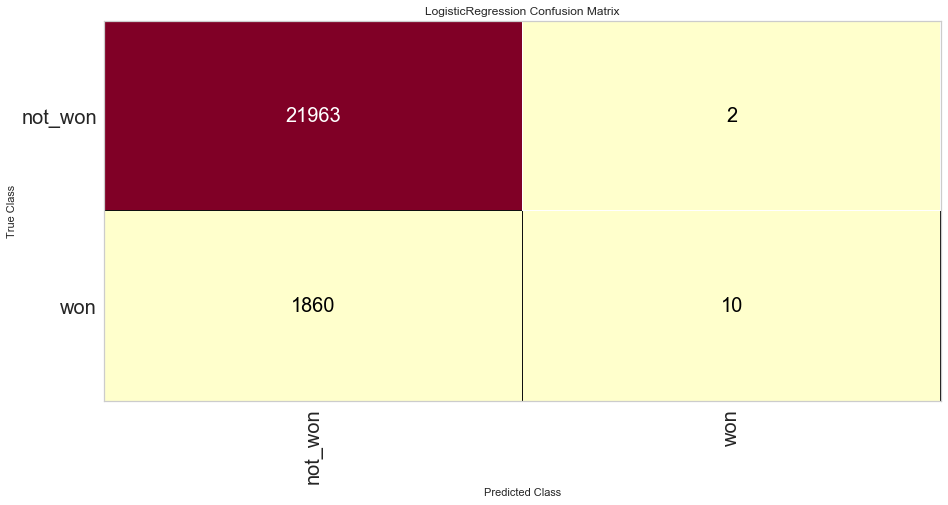

In [43]:
# Instantiate the classification model 
model_lr = LogisticRegression(solver='lbfgs', max_iter=150)

# The ConfusionMatrix visualizer taxes a model
classes = ['not_won','won']
cm = ConfusionMatrix(model_lr, classes=classes, percent=False)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit learn.
cm.score(X_val, y_val)

# change fontsize of the labels in the figure
for label in cm.ax.texts:
    label.set_size(20)

# How did we do?
cm.poof()

#### ii. Precision, Recall & F1 score  

> The results of Precision (high), Recall (low and high), and F1 Score (low and high) confirm that the model is not effective and is over-fitting. This could be due to the imbalanced nature of the data, and might suggest that another choice of model could be better, or that the hyperparameters for class weight could be adjusted.

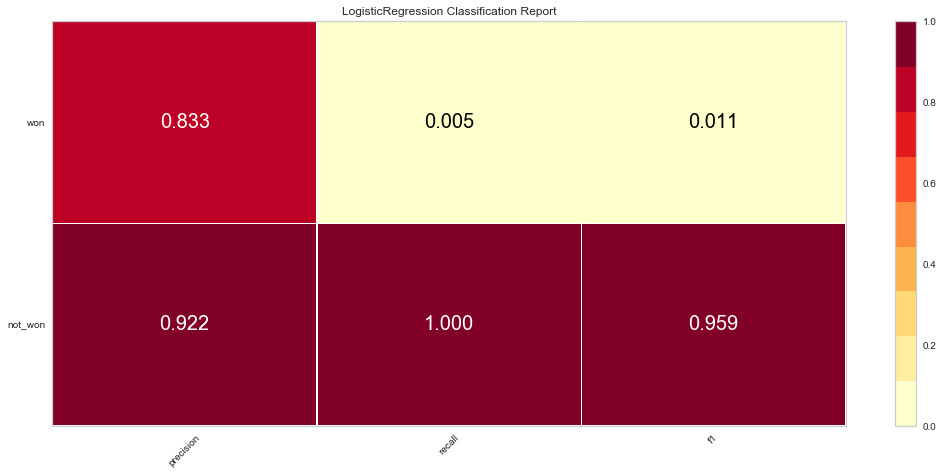

In [44]:
# Precision, Recall, and F1 Score

# set the size of the figure and the font size 
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 20

# Instantiate the visualizer
visualizer = ClassificationReport(model_lr, classes=classes)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_val, y_val)  # Evaluate the model on the test data
g = visualizer.poof()

#### ROC curve  

> The dotted line is the randomly guessed, so anything above that is good metric. The better the model, the closer it is to the solid line. From this visualization, the model is performing well, but we know that the classes are imbalanced, and there is definitely bias. If we had more data on horses that win for example, we might have a better model.

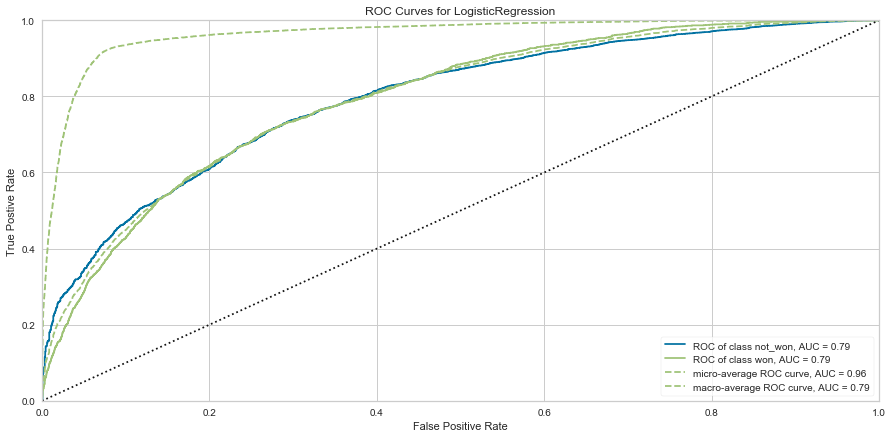

In [45]:
# ROC and AUC
#Instantiate the visualizer
visualizer = ROCAUC(model_lr)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_val, y_val)  # Evaluate the model on the test data
g = visualizer.poof()

References:

Daley, G. (2019, November 17). Horse Racing in HK. Kaggle. Retrieved from <https://www.kaggle.com/gdaley/hkracing>

Keith Prowse. (2018, May 16). Off to the races: A horse racing glossary. Retrieved from <https://www.keithprowse.co.uk/news-and-blog/2018/05/16/off-to-the-races---a-horse-racing-glossary/>